In [1]:
import math
import numpy as np
import pandas as pd
import torch
import gpytorch as gp
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
class prior(gp.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)

def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

def gap(best_found, best_init, best):
    ans = (best_found - best_init)/(best - best_init)
    return ans

In [3]:
svm = pd.read_csv("svm.csv")
best = np.min(np.log(svm["value"].values))

num_runs = 20
gaps = torch.zeros((num_runs, 30))
gaps_rand = torch.zeros((num_runs, 150))

for run in range(num_runs):
    D_idx = np.random.choice(range(1400), 5, replace=False)
    svm_init = svm.iloc[D_idx]
    svm_domain = svm.drop(index=D_idx)

    domain = torch.tensor(svm_domain[["C", "alpha", "epsilon"]].values)
    f = torch.log(torch.tensor(svm_domain["value"].values))
    
    D_X = torch.tensor(svm_init[["C", "alpha", "epsilon"]].values)
    D_y = torch.log(torch.tensor(svm_init["value"].values))
    D_fmin = torch.min(D_y)
    fmin_init = torch.min(D_y)

    domain_rand = domain.clone()
    f_rand = f.clone()
    D_X_rand = D_X.clone()
    D_y_rand = D_y.clone()
    D_fmin_rand = min(D_y_rand)
    
    budget = 30
    for t in range(budget):

        # Initialize model
        likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X.shape[0])*(0.01**2))
        k = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
        k.outputscale = 0.0215
        k.base_kernel.lengthscale = 1.1278
        model = prior(D_X, D_y, likelihood, k)
        model.mean_module.constant = torch.nn.parameter.Parameter(torch.tensor(-1.2247))

        # Measure EI
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = likelihood(model(domain), noise=torch.ones(domain.shape[0]) * (0.01**2))
        f_means = f_preds.mean.detach().numpy()
        f_stds = torch.sqrt(f_preds.variance).detach().numpy()
        a_eis = a_ei(D_fmin, f_means, f_stds)

        # Find Max EI and Observe
        max_idx = torch.argmax(a_eis)
        next_X = domain[max_idx]
        next_y = f[max_idx]
        D_X = torch.cat((D_X, next_X.reshape(1, -1)), dim=0)
        D_y = torch.cat((D_y, next_y.reshape(1)))
        D_fmin = torch.min(D_y)

        # Organize
        domain = torch.cat((domain[:max_idx], domain[max_idx+1:]), dim=0)
        f = torch.cat((f[:max_idx], f[max_idx+1:]))

        # Store gap
        gaps[run, t] = gap(D_fmin, fmin_init, best)

    budget_rand = 150
    for t_rand in range(budget_rand):
        next_idx = np.random.choice(domain_rand.shape[0])
        next_X = domain_rand[next_idx]
        next_y = f_rand[next_idx]
        D_X_rand = torch.cat((D_X_rand, next_X.reshape(1, -1)), dim=0)
        D_y_rand = torch.cat((D_y_rand, next_y.reshape(1)))
        D_fmin_rand = torch.min(D_y_rand)

        domain_rand = torch.cat((domain_rand[:next_idx], domain_rand[next_idx+1:]), dim=0)
        f_rand = torch.cat((f_rand[:next_idx], f_rand[next_idx+1:]))

        gaps_rand[run, t_rand] = gap(D_fmin_rand, fmin_init, best)

mean_gaps = torch.mean(gaps, dim=0)
mean_gaps_rand = torch.mean(gaps_rand, dim=0)

[]

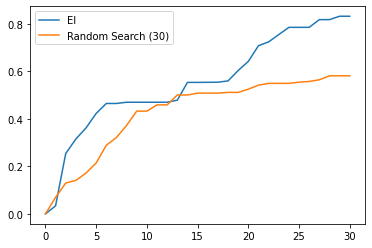

In [4]:
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps)), label='EI')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_rand[:30])), label='Random Search (30)')
plt.legend()
plt.plot()

In [5]:
print(ttest_ind(mean_gaps, mean_gaps_rand[:30], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[30:60], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[60:90], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[90:120], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[120:150], alternative="greater"))

Ttest_indResult(statistic=2.843117899500529, pvalue=0.003079455658482812)
Ttest_indResult(statistic=-2.4839340935726746, pvalue=0.9920478210105969)
Ttest_indResult(statistic=-4.257238770092044, pvalue=0.9999616747360703)
Ttest_indResult(statistic=-4.972949161906734, pvalue=0.9999969020074623)
Ttest_indResult(statistic=-6.400389205768545, pvalue=0.9999999852230933)
